# kNN for Document Similarity
In this notebook, we learn a kNN on the tagged dataset (corpus of research papers) and learn how tags are similar across the entire dataset (research papers), eventually we can retrieve the similar papers based on their relavance to the input tag.

In [366]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import tqdm, os, re, glob, json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import time
from sklearn import linear_model
from sklearn import svm
from sklearn.neighbors import NearestNeighbors
from IPython.display import display
from sklearn.neighbors import KNeighborsRegressor
import pprint
style.use('ggplot')
%matplotlib inline

In [2]:
basepath = "/Users/Janjua/Desktop/Projects/Octofying-COVID19-Literature/dataset"
datapath = "CORD-19-research-challenge"

In [5]:
tagged_texts_df = pd.read_csv((os.path.join(basepath, datapath) + "/tagged_texts.csv"))
display(tagged_texts_df)

,Tag,Full_Text
0,MERS-CoV response,While most CoVs cause the common cold in human...
1,infection influenza,Clinically relevant respiratory viral signatur...
2,population pathogen,The evolutionary history of humans is characte...
3,emission aviation,"Sixty years ago, civil aviation was an infant ..."
4,toxin diarrhoea,Acute infections of the gastrointestinal tract...
...,...,...
33370,lipid sample,Early nutritional environment affects long ter...
33371,patient syphilis,Syphilis is a sexually transmitted disease (ST...
33372,MERS-CoV Jamaican,Scientific RepoRts | 6:21878 | DOI: 10 .1038/s...
33373,U0126 cell,Arenaviruses are enveloped RNA viruses contain...


## TF-IDF Vectorization

In [254]:
tagged_texts = tagged_texts_df.Full_Text.astype('U').tolist()
tags = tagged_texts_df.Tag.astype('U').tolist()
print(len(tagged_texts), len(tags))

33375 33375


In [304]:
def get_n_chunks(lst, start, end):
    return lst[start:end]
        
def fit_vectorizer(corpus):
    pca = PCA(n_components=1)
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(corpus)
    X = pca.fit_transform(X.todense())
    return X

def compute_vectorization():
    vectorizer = TfidfVectorizer()
    vectorized_lst_X, vectorized_lst_y = [], []
    for ix in range(0, 33301, 375):
        start = time.time()
        chunk_X = get_n_chunks(tagged_texts, ix, ix+375)
        chunk_y = get_n_chunks(tags, ix, ix+375)
        X_vectorized = fit_vectorizer(chunk_X)
        y_vectorized = fit_vectorizer(chunk_y)
        vectorized_lst_X.append([x[0] for x in X_vectorized])
        vectorized_lst_y.append([x[0] for x in y_vectorized])
        end = time.time()
        print("Processed {}/{} in {}s".format(ix//375, 89, round(end-start, 4)))
        
    return (vectorized_lst_X, vectorized_lst_y)

X, y = compute_vectorization()
print('X Len: ', len(X), ' y Len: ', len(y))

Processed 0/89 in 3.0186s
Processed 1/89 in 3.5078s
Processed 2/89 in 4.2244s
Processed 3/89 in 5.4294s
Processed 4/89 in 7.1181s
Processed 5/89 in 7.1993s
Processed 6/89 in 5.6617s
Processed 7/89 in 5.0967s
Processed 8/89 in 7.1007s
Processed 9/89 in 7.8468s
Processed 10/89 in 9.6526s
Processed 11/89 in 7.6759s
Processed 12/89 in 8.3091s
Processed 13/89 in 9.1193s
Processed 14/89 in 5.8496s
Processed 15/89 in 5.1372s
Processed 16/89 in 4.6675s
Processed 17/89 in 4.3356s
Processed 18/89 in 4.2431s
Processed 19/89 in 3.9287s
Processed 20/89 in 4.0429s
Processed 21/89 in 4.0972s
Processed 22/89 in 3.769s
Processed 23/89 in 3.6458s
Processed 24/89 in 4.0214s
Processed 25/89 in 4.2078s
Processed 26/89 in 3.7846s
Processed 27/89 in 3.7091s
Processed 28/89 in 4.537s
Processed 29/89 in 4.0695s
Processed 30/89 in 4.2967s
Processed 31/89 in 4.6026s
Processed 32/89 in 3.848s
Processed 33/89 in 4.2411s
Processed 34/89 in 4.5517s
Processed 35/89 in 4.548s
Processed 36/89 in 4.3528s
Processed 37/89

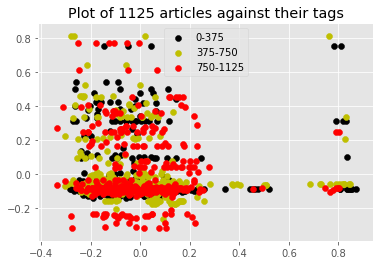

In [305]:
plt.scatter(X[0], y[0], color='k', label='0-375')
plt.scatter(X[1], y[1], color='y', label='375-750')
plt.scatter(X[2], y[2], color='r', label='750-1125')
plt.legend()
plt.title('Plot of 1125 articles against their tags')
plt.show()

In [306]:
flatten = lambda lst: [i for j in lst for i in j]
X_flat = flatten(X)
y_flat = flatten(y)
print('X_flat Len: ', len(X_flat), ' y_flat Len: ', len(y_flat))

X_flat Len:  33375  y_flat Len:  33375


In [307]:
vectorized_data = []
for ix in range(len(X_flat)):
    vectorized_data.append((X_flat[ix], y_flat[ix]))
vectorized_df = pd.DataFrame(vectorized_data, columns = ['Tag', 'Full_Text'])
display(vectorized_df)
vectorized_df.to_csv(os.path.join(basepath, datapath) + "/vectorized_tagged_texts.csv")

,Tag,Full_Text
0,-0.069830,-0.108485
1,-0.011791,0.235946
2,-0.109490,-0.100011
3,0.058793,-0.087165
4,-0.171609,-0.090950
...,...,...
33370,0.100810,-0.063140
33371,-0.094654,-0.192202
33372,0.124071,-0.078116
33373,0.037119,-0.107651


In [368]:
X_train, y_train = [], []
for ix in range(len(X_flat)):
    X_train.append([X_flat[ix]])
    y_train.append([y_flat[ix]])
X_train_arr = np.asarray(X_train)
y_train_arr = np.asarray(y_train)

In [437]:
def read_papers():
    papers = [x for x in glob.glob(os.path.join(basepath, datapath) + "/*/*/*.json")]
    papers_contents = []
    for paper in tqdm.tqdm(papers):
        read_paper = json.load(open(paper))
        paper_id = read_paper["paper_id"]
        title = read_paper['metadata']['title']
        try:
            abstract = read_paper['abstract'][0]['text']
        except:
            abstract = "No abstract found"
        paper_text = ""
        for text in read_paper['body_text']:
            paper_text += text['text'] + '\n\n'
        papers_contents.append([paper_id, title, abstract, paper_text])
    return papers_contents

papers = read_papers()
df_covid = pd.DataFrame(papers, columns=["id", "title", "abstract", "text"])
display(df_covid.head())

100%|██████████| 33375/33375 [01:32<00:00, 358.90it/s]


,id,title,abstract,text
0,86a998617c077f4fe2ab26214995a3548fbc0fc5,Middle East Respiratory Syndrome and Severe Ac...,The recent emergence of the Middle East respir...,While most CoVs cause the common cold in human...
1,948aaeb2e0be11ad90562bf10d462531a1f00eac,"Integrated, Multi-cohort Analysis Identifies C...",Graphical Abstract Highlights d MVS is a commo...,Clinically relevant respiratory viral signatur...
2,ab680d5dbc4f51252da3473109a7885dd6b5eb6f,Evolutionary Medicine IV. Evolution and Emerge...,No abstract found,The evolutionary history of humans is characte...
3,6599ebbef3d868afac9daa4f80fa075675cf03bc,International aviation emissions to 2025: Can ...,"International aviation is growing rapidly, res...","Sixty years ago, civil aviation was an infant ..."
4,eb5c7f3ff921ad6469b79cc8a3c122648204ece4,2 Mechanisms of diarrhoea,No abstract found,Acute infections of the gastrointestinal tract...


In [443]:
titles = df_covid.title.tolist()
ids = df_covid.id.tolist()

def fit_kNN_model(X_train):
    kNN = NearestNeighbors(n_neighbors=10)
    kNN.fit(X_train)
    return kNN

def get_similar_papers(kNN, value):
    dist, index = kNN.kneighbors(value)
    ids_to_retrieved_papers = {}
    for indice in index[0]:
        ret_title = titles[indice]
        ret_ids = ids[indice]
        if len(ret_title) > 0:
            ids_to_retrieved_papers[ret_ids] = ret_title
        else:
            pass
    return ids_to_retrieved_papers
        
kNN = fit_kNN_model(X_train_arr)
get_similar_papers(kNN, y_train_arr[1].reshape(-1,1))

{'634b8c282afdd06201cb2531fb70985d92270271': 'In Situ Tagged nsp15 Reveals Interactions with Coronavirus Replication/Transcription Complex- Associated Proteins',
 '57b32baae9c8cfd1be336a341fe0df2a55ad57bb': 'In Situ Tolerance within the Central Nervous System As a Mechanism for Preventing Autoimmunity',
 '11416bee008daf3c42621002ba7f3a6939601b0d': 'High-Mannose But Not Complex-Type Glycosylation of Tetherin Is Required for Restriction of HIV-1 Release',
 '5aaa0dfb49b42f8fab7ce125f89360b828ee9298': 'Cyclosporin A and Its Analogs Inhibit Hepatitis B Virus Entry Into Cultured Hepatocytes Through Targeting a Membrane Transporter, Sodium Taurocholate Cotransporting Polypeptide (NTCP)',
 '6e512f8c833fc376bc96c988172928ac0ce385e8': 'POSSIBLE IMMUN(ENHANCEMENT OF PERSISTENT VIREMIA BY FELINE LEUKEMIA VII~S ENVELOPE GLYCOPRUI~IN VACCINES IN CHATJ.ENGE-EXPOSURE SITUATIONS W}ERE WHOLE INACTIVATED VIRUS VACCINES ~RE PROTECTIVE',
 '8fcf1d545d5c10fbe83bbbd9dab8391fb748be7f': 'The ability to suppress

In [433]:
meta_files = pd.read_csv((os.path.join(basepath, datapath) + "/metadata.csv"))
display(meta_files)

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text,full_text_file,url
0,vho70jcx,f056da9c64fbf00a4645ae326e8a4339d015d155,biorxiv,SIANN: Strain Identification by Alignment to N...,10.1101/001727,NaN,NaN,biorxiv,Next-generation sequencing is increasingly bei...,2014-01-10,Samuel Minot; Stephen D Turner; Krista L Ternu...,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/001727
1,i9tbix2v,daf32e013d325a6feb80e83d15aabc64a48fae33,biorxiv,Spatial epidemiology of networked metapopulati...,10.1101/003889,NaN,NaN,biorxiv,An emerging disease is one infectious epidemic...,2014-06-04,Lin WANG; Xiang Li,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/003889
2,62gfisc6,f33c6d94b0efaa198f8f3f20e644625fa3fe10d2,biorxiv,Sequencing of the human IG light chain loci fr...,10.1101/006866,NaN,NaN,biorxiv,Germline variation at immunoglobulin gene (IG)...,2014-07-03,Corey T Watson; Karyn Meltz Steinberg; Tina A ...,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/006866
3,058r9486,4da8a87e614373d56070ed272487451266dce919,biorxiv,Bayesian mixture analysis for metagenomic comm...,10.1101/007476,NaN,NaN,biorxiv,Deep sequencing of clinical samples is now an ...,2014-07-25,Sofia Morfopoulou; Vincent Plagnol,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/007476
4,wich35l7,eccef80cfbe078235df22398f195d5db462d8000,biorxiv,Mapping a viral phylogeny onto outbreak trees ...,10.1101/010389,NaN,NaN,biorxiv,Developing methods to reconstruct transmission...,2014-11-11,Stephen P Velsko; Jonathan E Allen,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/010389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45769,4360s2yu,289deae0b2050aa259a05ba84565a4df82fa099a,Elsevier,Personal Protective Equipment: Protecting Heal...,10.1016/j.clinthera.2015.07.007,PMC4661082,26452427.0,els-covid,Abstract Purpose The recent Ebola epidemic tha...,2015-11-01,"Fischer, William A.; Weber, David J.; Wohl, Da...",Clinical Therapeutics,NaN,NaN,True,custom_license,https://doi.org/10.1016/j.clinthera.2015.07.007
45770,66jumbir,21a4369f83891bf6975dd916c0aa495d5df8709e,Elsevier,Viruses and asthma,10.1016/j.bbagen.2011.01.012,PMC3130828,21291960.0,els-covid,Abstract Background Viral respiratory infectio...,2011-11-30,"Dulek, Daniel E.; Peebles, R. Stokes",Biochimica et Biophysica Acta (BBA) - General ...,NaN,NaN,True,custom_license,https://doi.org/10.1016/j.bbagen.2011.01.012
45771,3wk36h9p,NaN,Elsevier,Why the WHO won't use the p-word,10.1016/s0262-4079(20)30474-7,NaN,NaN,els-covid,"There are no criteria for a pandemic, but covi...",2020-03-07,"MacKenzie, Debora",New Scientist,NaN,#5716,False,custom_license,https://doi.org/10.1016/s0262-4079(20)30474-7
45772,0ujw0gak,NaN,WHO,"Communication, transparency key as Canada face...",10.1503/cmaj.1095846,PMC7030882,32071113.0,unk,NaN,2020-02-17,"Glauser, Wendy",Canadian Medical Association Journal,1.953688e+09,#4117,False,NaN,https://doi.org/10.1503/cmaj.1095846


In [469]:
def draw_horizontal_lines(times):
    print("="*times)
    
def retrieve_based_on_keyword(keyword):
    X = fit_vectorizer(keyword)
    X_arr = np.asarray(X)
    local_arr = []
    for ix in X_arr:
        local_arr.append(ix[0])
    var = np.var(local_arr)
    val = np.asarray(var).reshape(-1,1)
    ret_res = get_similar_papers(kNN, val)
    for ix in ret_res.items():
        id_, title = ix
        draw_horizontal_lines(100)
        url = list(meta_files.loc[meta_files['sha'] == id_]['url'])
        print('Title: ', title)
        try:
            print('URL: ', url[0])
        except:
            print('URL: ', 'No URL found')

retrieve_based_on_keyword(['pregnancy', 'women', 'child', 'pregnant', 'covid-19', 'dangers',
                                    'deaths', 'toxic', 'harmful'])

Title:  Novel circular single-stranded DNA viruses identified in marine invertebrates reveal high sequence diversity and consistent predicted intrinsic disorder patterns within putative structural proteins
URL:  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4498126/
Title:  Rapid Field Immunoassay for Detecting Antibody to Sin Nombre Virus in Deer Mice
URL:  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2851528/
Title:  Helicase of Type 2 Porcine Reproductive and Respiratory Syndrome Virus Strain HV Reveals a Unique Structure
URL:  No URL found
Title:  X-ray Structure and Enzymatic Activity Profile of a Core Papain- like Protease of MERS Coronavirus with utility for structure-based drug design OPEN
URL:  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5228125/
Title:  Elevations in D-dimer and C-reactive protein are associated with the development of osteonecrosis of the hip in HIV-infected adults
URL:  http://europepmc.org/articles/pmc5507350?pdf=render
Title:  Alterations in Nerve-Evoked 

In [ ]:
def retrieve_based_on_question(keyword):
    sent = keyword.split()
    X = fit_vectorizer(sent)
    X_arr = np.asarray(X)
    local_arr = []
    for ix in X_arr:
        local_arr.append(ix[0])
    var = np.var(local_arr)
    val = np.asarray(var).reshape(-1,1)
    ret_res = get_similar_papers(kNN, val)
    for ix in ret_res.items():
        id_, title = ix
        draw_horizontal_lines(100)
        url = list(meta_files.loc[meta_files['sha'] == id_]['url'])
        print('Title: ', title)
        try:
            print('URL: ', url[0])
        except:
            print('URL: ', 'No URL found')
            
question = input('What do you want to ask?')
print("The relevant papers for question {} are: \n\n".format(question))
retrieve_based_on_question(question)